## Combining ML1 ML2 and ML4 dataset after removing Batch Effect
### Experiments:
1. Z-score normalization independently on each dataset and combine dataset with stratified (label and batch).
2. Split the model 60/40 train the model and test

In [10]:
import warnings
warnings.filterwarnings('ignore')

import sys
import os
import pandas as pd
import numpy as np

sys.path.insert(0, '../')

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.base import clone
from sklearn.metrics import r2_score

from src.load_dataset import load_dataset
from src.utils import tsen_pca_viz, verify_batch_label_dist, calculate_r2_score, calculate_per_diff, per_error, find_adj_score, combine_all_batches, split_batches_back, perform_combat_normalization
from src.load_models import select_model
from src.graph_visualization import visualization_testing_dataset
from src.config import *

In [11]:
# Load dataset
normalization     = True
# Perform normalization
standardize_type  = 'mean_std' if normalization else 'none'  # select normalization type (min_max, mean_std)
split             = False                                    # Split batch dataset into training and testing set
combat_norm       = True                                    # apply combat normalization
normalize_blanks  = True
test_nor_separate = False


if split:
    (ML1_X_train, ML1_X_test, ML1_y_train, ML1_y_test), _  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1', normalization=normalization, standardize_type=standardize_type, normalize_blanks=normalize_blanks, test_nor_separate=test_nor_separate, split=split)
    (ML2_X_train, ML2_X_test, ML2_y_train, ML2_y_test), _  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_22_ML2', normalization=normalization, standardize_type=standardize_type, normalize_blanks=normalize_blanks, test_nor_separate=test_nor_separate, split=split)
    (ML4_X_train, ML4_X_test, ML4_y_train, ML4_y_test), _  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4', normalization=normalization, standardize_type=standardize_type, normalize_blanks=normalize_blanks, test_nor_separate=test_nor_separate, split=split)

else:
    ML1_X, ML1_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1', normalization=normalization, standardize_type=standardize_type, split=split)
    ML2_X, ML2_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_22_ML2', normalization=normalization, standardize_type=standardize_type, split=split)
    ML4_X, ML4_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4', normalization=normalization, standardize_type=standardize_type, split=split)

In [4]:
# Visualize PCA and t-SEN
if split:
    data_train          = pd.concat([ML1_X_train, ML2_X_train, ML4_X_train])
    batch_labels_train  = np.repeat(['ML1', 'ML2', 'ML4'], repeats= [len(ML1_X_train), len(ML2_X_train), len(ML4_X_train)])
    batch_labels_test   = np.repeat(['ML1', 'ML2', 'ML4'], repeats= [len(ML1_X_test),  len(ML2_X_test),  len(ML4_X_test)])
    
    labels_train = ML1_y_train.values.tolist() + ML2_y_train.values.tolist() + ML4_y_train.values.tolist()
    labels_test  = ML1_y_test.values.tolist()  + ML2_y_test.values.tolist()  + ML4_y_test.values.tolist()
    
    tsen_pca_viz([ML1_X_train, ML2_X_train, ML4_X_train], batch_labels_train, labels_train)
    tsen_pca_viz([ML1_X_test,  ML2_X_test,  ML4_X_test],  batch_labels_test,  labels_test)


In [26]:
ML1_X.shape

(130, 13)

In [25]:
ML1_X.nunique()

univariate, area(S)                    130
peak curvature                         130
univariate, V_max(S)                   116
vcenter                                 18
univariate, max(S)                     130
univariate, mean(S)                     81
univariate, std(S)                     102
univariate, max(dS/dV)                 130
univariate, min(dS/dV)                 130
univariate, max(dS/dV) - min(dS/dV)    129
univariate, V_max(dS/dV)                29
univariate, V_min(dS/dV)                28
univariate, area(dS/dV)                125
dtype: int64

In [5]:
# df = pd.DataFrame([ML1_X_test.mean(axis=0).values, ML2_X_test.mean(axis=0).values, ML4_X_test.mean(axis=0).values], columns=ML1_X_test.columns).round(5)
# df.index= ['ML1', 'ML2', 'ML4']
# df

In [6]:
# df = pd.DataFrame([ML1_X_test.std(axis=0).values, ML2_X_test.std(axis=0).values, ML4_X_test.std(axis=0).values], columns=ML1_X_test.columns).round(5)
# df.index= ['ML1', 'ML2', 'ML4']
# df

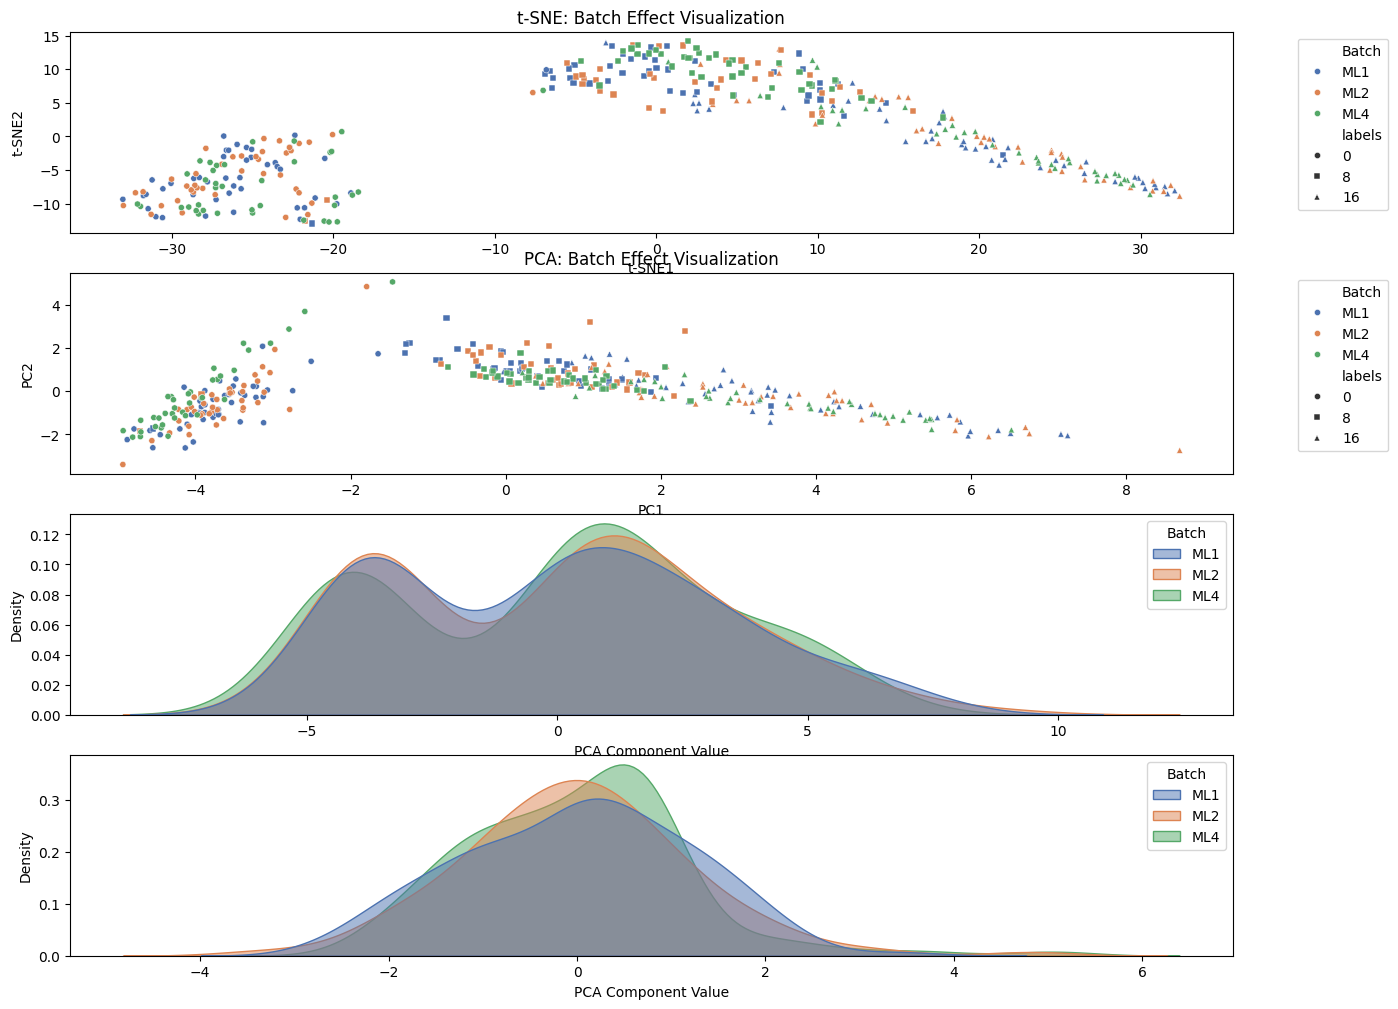

In [7]:
if combat_norm:
    if split:
        (ML1_X_train, ML2_X_train, ML4_X_train), batch_labels_train, combat = perform_combat_normalization([ML1_X_train, ML2_X_train, ML4_X_train], dataset_name=['ML1', 'ML2', 'ML4'])
    
        combine_batches = [ML1_X_test,  ML2_X_test,  ML4_X_test]
        
        # Perform ComBat Normalization in testing set
        features, batch_labels_test = combine_all_batches(combine_batches, ['ML1', 'ML2', 'ML4'])
    
        combat_transform            =  combat.transform(features.values, batch_labels_test)
        (ML1_X_test,  ML2_X_test,  ML4_X_test) = split_batches_back(combine_batches, combat_transform)
        
        labels_train = ML1_y_train.values.tolist() + ML2_y_train.values.tolist() + ML4_y_train.values.tolist()
        labels_test  = ML1_y_test.values.tolist()  + ML2_y_test.values.tolist()  + ML4_y_test.values.tolist()
        
        tsen_pca_viz([ML1_X_train, ML2_X_train, ML4_X_train], batch_labels_train, labels_train)
        tsen_pca_viz([ML1_X_test,  ML2_X_test,  ML4_X_test],  batch_labels_test, labels_test)

    else:
        (ML1_X, ML2_X, ML4_X), batch_labels,_ = perform_combat_normalization([ML1_X, ML2_X, ML4_X], dataset_name=['ML1', 'ML2', 'ML4'])
        labels               = ML1_y.values.tolist() + ML2_y.values.tolist() + ML4_y.values.tolist()
        tsen_pca_viz([ML1_X, ML2_X, ML4_X], batch_labels, labels)

It seems the mean is nearly equal to zero and std is 1

In [8]:
# perform stratified train test split
if split==False:
    X                = pd.concat([ML1_X, ML2_X, ML4_X], axis=0)
    y                = ML1_y.values.tolist() + ML2_y.values.tolist() + ML4_y.values.tolist()
    stratified_label = ML1_y.map(lambda x: f'ML1_{x}').values.tolist() + ML2_y.map(lambda x: f'ML2_{x}').values.tolist() + ML4_y.map(lambda x: f'ML4_{x}').values.tolist()
    
    X_train, X_test, y_train_strat, y_test_strat = train_test_split(X, stratified_label, test_size=0.4, shuffle=True, random_state=20, stratify=stratified_label)
    y_train, y_test = pd.Series(y_train_strat).map(lambda x: eval(x.split('_')[1])), pd.Series(y_test_strat).map(lambda x: eval(x.split('_')[1]))

else:
    y_train_strat = ML1_y_train.map(lambda x: f'ML1_{x}').values.tolist() + ML2_y_train.map(lambda x: f'ML2_{x}').values.tolist() + ML4_y_train.map(lambda x: f'ML4_{x}').values.tolist()
    y_test_strat  = ML1_y_test.map(lambda x: f'ML1_{x}').values.tolist() + ML2_y_test.map(lambda x: f'ML2_{x}').values.tolist() + ML4_y_test.map(lambda x: f'ML4_{x}').values.tolist()

    # Combine ML1, ML2, and ML4 dataset
    X_train, X_test, y_train, y_test =  pd.concat([ML1_X_train, ML2_X_train, ML4_X_train], axis=0).reset_index(drop=True), \
                                        pd.concat([ML1_X_test,  ML2_X_test,  ML4_X_test],  axis=0).reset_index(drop=True), \
                                        pd.concat([ML1_y_train, ML2_y_train, ML4_y_train], axis=0).reset_index(drop=True), \
                                        pd.concat([ML1_y_test,  ML2_y_test,  ML4_y_test],  axis=0).reset_index(drop=True)

    # Create shuffling index with random choice
    shuffle_ind_train = np.random.choice(range(len(X_train)), len(X_train), replace=False)
    assert len(np.unique(shuffle_ind_train))==len(X_train)
    
    shuffle_ind_test = np.random.choice(range(len(X_test)), len(X_test), replace=False)
    assert len(np.unique(shuffle_ind_test))==len(X_test)

    # Shuffle training dataset
    X_train, y_train = X_train.iloc[shuffle_ind_train], y_train.iloc[shuffle_ind_train]
    X_test,  y_test  = X_test.iloc[shuffle_ind_test],   y_test.iloc[shuffle_ind_test]

    # Check if the labels and features have same index after shuffling
    assert X_train.index.tolist()==y_train.index.tolist()
    assert X_test.index.tolist()==y_test.index.tolist()
    

## Verify training and testing distribution

In [9]:
# Verify the percentage of labels and batch
train_dist = verify_batch_label_dist(y_train_strat)
test_dist  = verify_batch_label_dist(y_test_strat)

print(train_dist)
print(test_dist)

              y
batch label    
ML1   0      26
      16     26
      8      25
ML2   0      24
      16     24
      8      22
ML4   0      23
      16     22
      8      24
              y
batch label    
ML1   0      18
      16     18
      8      17
ML2   0      16
      16     16
      8      14
ML4   0      15
      16     14
      8      17


In [ ]:
# List of models
models = ['Linear', 'KNN', 'SVM', 'RF', 'GP', 'Ridge', 'Lasso', 'univariate, std(S)', 'univariate, max(dS/dV)', 'univariate, area(dS/dV)', 'univariate, area(S)', 'univariate, max(S)']

# Calcualte y_LOD
y_LOD = 0.9117010154341669 #calculate_y_LOD(X_testing, y_testing)
#print("y_LOD", y_LOD)

kf = KFold(n_splits=5)

r2_score_val,  per_diff_val  = {'Models':[], 'Scores':[]}, {'Models':[], 'Scores':[]}
r2_score_test, per_diff_test = {'Models':[], 'Scores':[]}, {'Models':[], 'Scores':[]}

for model_name in models:
    model    = select_model(model_name)

    val_r2     = calculate_r2_score(model, X_train[models_features_r2[model_name]],  y_train, kf)
    val_per    = calculate_per_diff(model, X_train[models_features_per[model_name]], y_train, kf, y_LOD)

    r2_score_val['Scores'].append(val_r2)
    per_diff_val['Scores'].append(val_per)

    model_r2  = clone(model)
    model_r2.fit(X_train[models_features_r2[model_name]], y_train)
    y_pred_r2 = model_r2.predict(X_test[models_features_r2[model_name]])

    r2_test_score = r2_score(y_test, y_pred_r2)
    adj_r2_test   = find_adj_score(len(y_pred_r2), len(models_features_r2[model_name]), r2_test_score)
    
    r2_score_test['Scores'].append((r2_test_score, adj_r2_test))

    model_per_diff = clone(model)
    model_per_diff.fit(X_train[models_features_per[model_name]], y_train)
    y_pred_per_diff = model_per_diff.predict(X_test[models_features_per[model_name]])
    
    per_diff_test['Scores'].append(per_error(y_test, y_pred_per_diff, y_LOD))

    r2_score_val['Models'].append(model_name)
    per_diff_val['Models'].append(model_name) 
    r2_score_test['Models'].append(model_name)
    per_diff_test['Models'].append(model_name)


In [ ]:
savedir   = f'../results/combined_ML1_ML2_ML4/normalization_{standardize_type}_combatNorm_{combat_norm}_split_{split}_testNorSeparate_{test_nor_separate}_blank_{normalize_blanks}'
adj_score = False

os.makedirs(savedir, exist_ok=True)

visualization_testing_dataset(r2_score_val,  f'{savedir}/r2_score_val.png',   model_name_conversion, only_one_multivariate=False, adj_score=adj_score, legends=True)
visualization_testing_dataset(per_diff_val, f'{savedir}/per_error_val.png', model_name_conversion, only_one_multivariate=False, r2_score=False, adj_score=False, legends=True)

visualization_testing_dataset(r2_score_test,  f'{savedir}/r2_score_test.png',   model_name_conversion, only_one_multivariate=False, adj_score=adj_score, legends=True)
visualization_testing_dataset(per_diff_test, f'{savedir}/per_error_test.png', model_name_conversion, only_one_multivariate=False, r2_score=False, adj_score=False, legends=True)